Copy this notebook (File>Save a copy in Drive), rename it using your name, and then work on your copy.
==
To send me your work: use the sharing menu (top-right of the window) to share it with timothee.m.r.bernard@gmail.com.
(I don't check this address very often, so, for questions, please use Moodle or my u-paris.fr address.)

Goal
==

We are about to design and train a neural system to perform sentiment analysis on film reviews. More precisely, the network will have to output the probability that the input review expresses a positive opinion (overall).

The system will be a bag-of-words model using GloVe embeddings. It will have to first average the embeddings of the words of the input review, and then send the result through a simple network that should output a probability.

There is a lot of code already written at the beginning of the notebook. It is important that you understand it as you will have to reuse/reproduce it for future work.

Remarks:
==
*   Follow the instructions very carefully. Do not ignore any comment.
*   Keep in mind all remarks given in TP 1.
*   Comment your code (including the role of all functions and the type of their arguments). A piece of code not appropriately commented can be considered incorrect (irrespectively of whether it works or not).
*   Indicate the shape of each tensor that you define.
*   Comment all the changes that you make. Any work that is not properly explained might be ignored.

Loading PyTorch is important.
==

In [ ]:
# Imports PyTorch.
import torch
import torch.nn.functional as F

Downloading the dataset
==
The dataset we are going to use is the Large Movie Review Dataset (https://ai.stanford.edu/~amaas/data/sentiment/).

Downloading the dataset and pre-processing it might take several minutes, so ask Colab to execute all cells while you are reading the code.

In [ ]:
# Downloads the dataset.
import urllib

tmp = urllib.request.urlretrieve("https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")
filename = tmp[0]

In [ ]:
filename

'/tmp/tmpimmna76p'

In [ ]:
# Extracts the dataset.
import tarfile
tar = tarfile.open(filename)
tar.extractall()
tar.close()

In [ ]:
import os # Useful library to read files and inspect directories.

In [ ]:
# Shows which files and directories are present at the root of the file system.
for filename in os.listdir("."):
  print(filename)

.config
aclImdb
sample_data


In [ ]:
dataset_root = "aclImdb"
# Shows which files and directories are present at the root of the dataset directory.
for filename in os.listdir(dataset_root):
  print(filename)

test
README
imdbEr.txt
train
imdb.vocab


In [ ]:
# Shows several reviews.
dirname = os.path.join(dataset_root, "train", "neg") # "aclImdb/{train|test}/{neg|pos}"
for idx, filename in enumerate(os.listdir(dirname)):
  if(idx >= 5): break # Stops after the 5th file.

  print(filename)
  with open(os.path.join(dirname, filename)) as f:
    review = f.read()
    print(review)
  print()

7168_4.txt
The writer came up with a pretty decent idea for a story, but many flaws in the execution of the plot took so much away from the film as to nearly render it unwatchable. Basic elements such as character development were glossed over, at best. Inconsistencies also reared their ugly heads. A massive mansion in the middle of the rural Irish countryside? Characters just "showing up" in the gardens during a stormy night (at very convenient times, I might add)? All in all it wasn't "bad". I rated it a 4, based mostly on the story and talent of Alison Elliott.

2873_1.txt
This movie features a gorgeous brunette named Danielle Petty. She has stunning green eyes, and is in the first few scenes and the last scene. She is the only thing about this movie that is not repulsive. She may not have a future as an actress, because this kind of movie is the kind of offensive disaster that kills careers.<br /><br />The movie itself has absolutely nothing to recommend it. It is not a good horror

Preprocessing the dataset
==

In [ ]:
import nltk # Imports NLTK, an NLP library.
nltk.download('punkt') # Loads a module required for tokenization.
import collections # This library defines useful data structures.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
newline = "<br />" # The reviews sometimes contain this HTLM tag to indicate a line break.
def preprocess(text):
  text = text.replace(newline, " ") # Replaces the newline HTML tag with a space.
  tokens = nltk.word_tokenize(text); # Converts the text to a list of tokens (strings).
  tokens = [token.lower() for token in tokens] # Lowercases all tokens.

  return tokens

# Reads and pre-processes the reviews.
dataset = {"train": [], "test": []}
binary_classes = {"neg": 0, "pos": 1}
for part_name, l in dataset.items():
  for class_name, value in binary_classes.items():
    path = os.path.join(dataset_root, part_name, class_name)
    print("Processing %s..." % path, end='');
    for filename in os.listdir(path):
        with open(os.path.join(path, filename)) as f:
          review_text = f.read()
          review_tokens = preprocess(review_text)

          l.append((review_tokens, value))
    print(" done")

Processing aclImdb/train/neg... done
Processing aclImdb/train/pos... done
Processing aclImdb/test/neg... done
Processing aclImdb/test/pos... done


In [ ]:
# Splits the train set into a proper train set and a development/validation set.
# 'dataset["train"]' happens to be a list composed of a certain number of negative examples followed by the same number of positive examples.
# We are going to use 3/4 of the original train set as our actual train set, and 1/4 as our development set.
# We want to keep balanced train and development sets, i.e. for both, half of the reviews should be positive and half should be negative.
if("dev" in dataset): print("This should only be run once.")
else:
  dev_set_half_size = int((len(dataset["train"]) / 4) / 2) # Half of a quarter of the training set size.
  dataset["dev"] = dataset["train"][:dev_set_half_size] + dataset["train"][-dev_set_half_size:] # Takes some negative examples at the beginning and some positive ones at the end.
  dataset["train"] = dataset["train"][dev_set_half_size:-dev_set_half_size] # Removes the examples used for the development set.

  for (part, data) in dataset.items():
    class_counts = collections.defaultdict(int)
    for (_, p) in data: class_counts[p] += 1
    print(f"{part}: {class_counts}")
  print("Train set split into train/dev.")

train: defaultdict(<class 'int'>, {0: 9375, 1: 9375})
test: defaultdict(<class 'int'>, {0: 12500, 1: 12500})
dev: defaultdict(<class 'int'>, {0: 3125, 1: 3125})
Train set split into train/dev.


Loading the word embeddings
==
We are going to use GloVe embeddings.

All word forms with a frequency below a given threshold are going to be considered unknown forms.

In [ ]:
# Computes the frequency of all word forms in the train set.
word_counts = collections.defaultdict(int)
for tokens, _ in dataset["train"]:
  for token in tokens: word_counts[token] += 1

print(word_counts)

defaultdict(<class 'int'>, {'this': 56889, 'movie': 32359, 'was': 37784, 'awful': 1232, '.': 205065, 'the': 250663, 'ending': 1707, 'absolutely': 1090, 'horrible': 922, 'there': 14085, 'no': 9347, 'plot': 4762, 'to': 101297, 'whatsoever': 239, 'only': 8891, 'thing': 3409, 'that': 55134, 'decent': 852, 'about': 13013, 'acting': 4794, 'done': 2268, 'by': 16990, 'robert': 729, 'duvall': 52, 'and': 122471, 'james': 794, 'earl': 57, 'jones': 296, 'their': 8489, 'performances': 1367, 'were': 8479, 'excellent': 1542, '!': 18140, 'problem': 1094, 'did': 7820, 'not': 23782, 'do': 13235, 'any': 5720, 'justice': 318, 'if': 12527, 'script': 2219, 'would': 10155, 'have': 21330, 'come': 2361, 'close': 856, 'capturing': 71, 'a': 121942, 'halfway': 129, 'story': 8732, ',': 207455, 'it': 71972, 'be': 20096, 'worth': 1684, 'watching': 3411, 'instead': 1615, "'s": 47144, "'": 7702, 'are': 22766, 'completely': 1434, 'wasted': 434, 'on': 25489, 'god': 857, 'storyline': 604, '...': 7227, 'or': 13364, 'lack'

In [ ]:
# Builds a vocabulary containing only those words present in the train set with a frequency above a given threshold.
count_threshold = 4;
vocabulary = set()
for word, count in word_counts.items():
    if(count > count_threshold): vocabulary.add(word)

print(vocabulary)
print(len(vocabulary))

{'salacious', 'expendable', 'bell', 'penalty', '1985', 'accommodate', ']', '^', 'embassy', 'accomplishes', 'cowgirls', 'inability', 'apparent', 'paintball', 'remastered', 'permanent', 'whores', 'chronologically', 'lucy', 'paolo', 'wizardry', 'scheduled', 'para', 'nominees', 'puddle', 'inexplicable', 'murders', 'prakash', 'proclaiming', 'jd', 'mulroney', '”', 'troopers', 'individuality', 'strives', 'deco', 'objects', 'crossing', 'hundred', 'vibrator', 'materialism', "'hippies", 'restraint', 'violation', 'simon', 'postures', 'st.', 'inconsistencies', 'batting', 'emptiness', 'surgery', 'vibrant', 'no-one', 'premiered', 'srk', 'cacophony', 'ceilings', 'askey', 'charis', 'exit', 'parkins', 'remarks', 'brooklyn', 'abbreviated', 'unisol', 'satellite', 'stigmata', 'stomachs', 'bundy', 'tomboy', 'hmm', 'mugs', 'counters', 'danning', 'sheppard', '1900s', 'planted', 'spades', 'hormone', 'aviv', 'craps', 'well-mannered', 'ethic', 'pursuit', 'ralphie', 'safer', "'60", 'malik', 'keifer', 'puppet', '

In [ ]:
import zipfile
import numpy as np

In [ ]:
# Returns a dictionary {word[String]: id[Integer]} and a list of Numpy arrays.
# `data_path` is the path of the directory containing the GloVe files (if None, 'glove.6B' is used)
# `max_size` is the number of word embeddings read (starting from the most frequent; in the GloVe files, the words are sorted)
# If `vocabulary` is specified (as a set of strings, or a dictionary from strings to integers), the output vocabulary contains the intersection of `vocabulary` and the words with a defined embedding. Otherwise, all words with a defined embedding are used.
def get_glove(dim=50, vocabulary=None, max_size=-1, data_path=None):
  dimensions = set([50, 100, 200, 300]) # Available dimensions for GloVe 6B
  fallback_url = 'http://nlp.stanford.edu/data/glove.6B.zip' # (Remember that in GloVe 6B, words are lowercased.)

  assert (dim in dimensions), (f'Unavailable GloVe 6B dimension: {dim}.')

  if(data_path is None): data_path = 'glove.6B'

  # Checks that the data is here, otherwise downloads it.
  if(not os.path.isdir(data_path)):
    #print('Directory "%s" does not exist. Creation.' % data_path)
    os.makedirs(data_path)

  glove_weights_file_path = os.path.join(data_path, f'glove.6B.{dim}d.txt')

  if(not os.path.isfile(glove_weights_file_path)):
    local_zip_file_path = os.path.join(data_path, os.path.basename(fallback_url))

    if(not os.path.isfile(local_zip_file_path)):
      print(f'Retreiving GloVe embeddings from {fallback_url}.')
      urllib.request.urlretrieve(fallback_url, local_zip_file_path)

    with zipfile.ZipFile(local_zip_file_path, 'r') as z:
      print(f'Extracting GloVe embeddings from {local_zip_file_path}.')
      z.extractall(path=data_path)

  assert os.path.isfile(glove_weights_file_path), (f"GloVe file {glove_weights_file_path} not found.")

  # Reads GloVe data.
  print('Reading GloVe embeddings.')
  new_vocabulary = {} # A dictionary {word[String]: id[Integer]}
  embeddings = [] # The list of embeddings (Numpy arrays)
  with open(glove_weights_file_path, 'r') as f:
    for line in f: # Each line consist of the word followed by a space and all of the coefficients of the vector separated by a space.
      values = line.split()

      # Here, I'm trying to detect where on the line the word ends and where the vector begins. As in some version(s) of GloVe words can contain spaces, this is not entirely trivial.
      vector_part = ' '.join(values[-dim:])
      x = line.find(vector_part)
      word = line[:(x - 1)]

      if((vocabulary is not None) and (not word in vocabulary)): # If a vocabulary was specified and if the word is not it…
        continue # …this word is skipped.

      new_vocabulary[word] = len(new_vocabulary)
      embedding = np.asarray(values[-dim:], dtype=np.float32)
      embeddings.append(embedding)

      if(len(new_vocabulary) == max_size): break
  print('(GloVe embeddings loaded.)')
  print()

  return (new_vocabulary, embeddings)

In [ ]:
%%time
(new_vocabulary, embeddings) = get_glove(dim=50, vocabulary=vocabulary)

Retreiving GloVe embeddings from http://nlp.stanford.edu/data/glove.6B.zip.
Extracting GloVe embeddings from glove.6B/glove.6B.zip.
Reading GloVe embeddings.
(GloVe embeddings loaded.)

CPU times: user 19.9 s, sys: 4.97 s, total: 24.9 s
Wall time: 3min 12s


In [ ]:
print(len(new_vocabulary)) # Shows the size of the vocabulary.
print(new_vocabulary) # Shows each word and its id.

25597
{'the': 0, ',': 1, '.': 2, 'of': 3, 'to': 4, 'and': 5, 'in': 6, 'a': 7, "'s": 8, 'for': 9, '-': 10, 'that': 11, 'on': 12, 'is': 13, 'was': 14, 'said': 15, 'with': 16, 'he': 17, 'as': 18, 'it': 19, 'by': 20, 'at': 21, '(': 22, ')': 23, 'from': 24, 'his': 25, "''": 26, '``': 27, 'an': 28, 'be': 29, 'has': 30, 'are': 31, 'have': 32, 'but': 33, 'were': 34, 'not': 35, 'this': 36, 'who': 37, 'they': 38, 'had': 39, 'i': 40, 'which': 41, 'will': 42, 'their': 43, ':': 44, 'or': 45, 'its': 46, 'one': 47, 'after': 48, 'new': 49, 'been': 50, 'also': 51, 'we': 52, 'would': 53, 'two': 54, 'more': 55, "'": 56, 'first': 57, 'about': 58, 'up': 59, 'when': 60, 'year': 61, 'there': 62, 'all': 63, '--': 64, 'out': 65, 'she': 66, 'other': 67, 'people': 68, "n't": 69, 'her': 70, 'percent': 71, 'than': 72, 'over': 73, 'into': 74, 'last': 75, 'some': 76, 'government': 77, 'time': 78, '$': 79, 'you': 80, 'years': 81, 'if': 82, 'no': 83, 'world': 84, 'can': 85, 'three': 86, 'do': 87, ';': 88, 'president':

Batch generator
==

In [ ]:
# Defines a class of objects that produce batches from the dataset.
class BatchGenerator:
  def __init__(self, dataset, vocabulary):
    self.dataset = dataset
    for part in self.dataset.values(): # Shuffles the dataset so that positive and negative examples are mixed.
      np.random.shuffle(part)

    self.vocabulary = vocabulary # Dictonary {word[String]: id[Integer]}
    self.unknown_word_id = len(vocabulary) # Id for unknown forms
    self.padding_idx = len(vocabulary) + 1 # Not all reviews of a given batch will have the same length. We will "pad" shorter reviews with a special token id so that the batch can be represented by a matrix.

  def length(self, data_type='train'):
    return len(self.dataset[data_type])

  # Returns a random batch.
  # Batches are output as a triples (word_ids, polarity, texts).
  # If `subset` is an integer, only a subset of the corpus is used. This can be useful to debug the system.
  def get_batch(self, batch_size, data_type, subset=None):
    data = self.dataset[data_type] # selects the relevant portion of the dataset.

    max_i = len(data) if(subset is None) else min(subset, len(data))
    instance_ids = np.random.randint(max_i, size=batch_size) # Randomly picks some instance ids.

    return self._ids_to_batch(data, instance_ids)

  def _ids_to_batch(self, data, instance_ids):
    word_ids = [] # Will be a list of lists of word ids (Integer)
    polarity = [] # Will be a list of review polarities (Boolean)
    texts = [] # Will be a list of lists of words (String)
    for instance_id in instance_ids:
      text, p = data[instance_id]

      word_ids.append([self.vocabulary.get(w, self.unknown_word_id) for w in text])
      polarity.append(p)
      texts.append(text)

    # Padding
    self.pad(word_ids)

    word_ids = torch.tensor(word_ids, dtype=torch.long) # Conversion to a tensor
    polarity = torch.tensor(polarity, dtype=torch.bool) # Conversion to a tensor

    return (word_ids, polarity, texts) # We don't really need `texts` but it might be useful to debug the system.

  # Pads a list of lists (i.e. adds fake word ids so that all sequences in the batch have the same length, so that we can use a matrix to represent them).
  # In place
  def pad(self, word_ids):
    max_length = max([len(s) for s in word_ids])
    for s in word_ids: s.extend([self.padding_idx] * (max_length - len(s)))

  # Returns a generator of batches for a full epoch.
  # If `subset` is an integer, only a subset of the corpus is used. This can be useful to debug the system.
  def all_batches(self, batch_size, data_type="train", subset=None):
    data = self.dataset[data_type]

    max_i = len(data) if(subset is None) else min(subset, len(data))

    # Loop that generates all full batches (batches of size 'batch_size').
    i = 0
    while((i + batch_size) <= max_i):
      instance_ids = np.arange(i, (i + batch_size))
      yield self._ids_to_batch(data, instance_ids)
      i += batch_size

    # Possibly generates the last (not full) batch.
    if(i < max_i):
      instance_ids = np.arange(i, max_i)
      yield self._ids_to_batch(data, instance_ids)

  # Turns a list of arbitrary pre-processed texts into a batch.
  # This function will be used to infer the polarity of a unannotated review.
  def turn_into_batch(self, texts):
    word_ids = [[self.vocabulary.get(w, self.unknown_word_id) for w in text] for text in texts]
    self.pad(word_ids)
    return torch.tensor(word_ids, dtype=torch.long)

batch_generator = BatchGenerator(dataset=dataset, vocabulary=new_vocabulary)
print(batch_generator.length('train')) # Prints the number of instance in the train set.

18750


In [ ]:
tmp = batch_generator.get_batch(3, data_type="train")
print(tmp[0]) # Prints the matrix of token ids. This matrix is what will be fed as input to the model (defined below).
print(tmp[1]) # Prints the vector of polarities. This vector will be used to compute the loss when training the model.
print(tmp[2]) # Prints the list of reviews.

tensor([[    0,  6575, 10550,  ..., 25598, 25598, 25598],
        [12288,  9559,   441,  ...,   552,  4861,     2],
        [  161, 25597,     3,  ..., 25598, 25598, 25598]])
tensor([False, False,  True])
[['the', 'incredible', 'melting', 'man', 'plays', 'like', 'an', 'extended', 'episode', 'of', 'the', 'six', 'million', 'dollar', 'man', ',', 'but', 'with', 'violence', 'and', 'some', 'nudity', '.', 'i', 'know', 'this', 'film', 'is', 'a', 'bit', 'crummy', 'but', 'i', 'found', 'it', 'impossible', 'not', 'to', 'kind', 'of', 'like', 'it', '.', 'the', 'acting', 'and', 'script', 'are', 'not', 'the', 'best', '.', 'but', 'the', 'effects', 'are', 'good', 'for', 'a', '30', 'year', 'old', 'movie', 'with', 'a', 'budget', 'of', '$', '50', '-', 'the', 'title', 'character', 'takes', 'quite', 'a', 'while', 'to', 'actually', 'melt', 'but', 'when', 'he', 'does', 'it', "'s", 'reasonably', 'impressive', ';', 'we', 'also', 'have', 'one', 'inventive', 'death', 'scene', 'involving', 'electrocution', '.', 'of

In [ ]:
len(list(batch_generator.all_batches(batch_size=3, data_type="train"))) # Number of batches in the training set for batches of size 3

6250

The model
==
Here you have to complete the implementation of the model.
This model is expected to accept as input a matrix of token ids (in which each line represents a review) and to output a vector (in which each value represents the probability that the corresponding review is positive).

Please, **pay attention to all comments**.
They contain useful information.

You might wonder what the `.to` method of tensors is for.
To execute the neural network faster, we will run it on a GPU instead of a CPU.
To do so, data and parameters should be sent on the GPU, which is done by using the `.to` method.
This is possible if the parameters of the notebook allow it (i.e. if Edit/Notebook Settings/Hardware Accelerator is "GPU"), which should be the case.
If you implement things correctly, you should not need to add any call to the `.to` method here (and only one or two later during the training process).

For your system to be efficient, you should **never loop over a tensor** whenever it is possible to do otherwise.

In [ ]:
class SentimentClassifier(torch.nn.Module):
  # embeddings: list of Numpy arrays
  # hidden_sizes: list of the size (Integer) of each hidden layer; there may be 0 or more hidden layers
  # freeze_embeddings: boolean; indicates whether the embeddings should be frozen (i.e., not fine-tuned) during training
  # device: string; indicates on which type of hardware PyTorch computation should be run
  # dropout_rate: indicates at which rate (probability) the network should randomly drop out neurons in a layer
  def __init__(self, embeddings, hidden_sizes, freeze_embeddings=True, device='cpu', dropout_rate=0.5):
    embeddings = list(embeddings) # Creates a copy of the list of embeddings, so we can add or remove entries without affecting the original list.
    super().__init__() # Calls the constructor of the parent class. Usually, this is necessary when creating a custom module.

    # Here you have to (i) define a vector for unknown forms (the average of actual word embeddings) and a vector for the padding token (full of 0·s) and (ii) define an embedding layer 'self.embeddings' using torch.nn.Embedding.from_pretrained and without forgetting to use the 'freeze' and 'padding_idx' arguments (this last argument is used to keep the padding embedding at 0 even when fine-tuning the other embeddings).
    # The following error (if you get it) indicates that the value provided for 'padding_idx' does not correspond to any embedding in the matrix that you provide (in other words, the matrix is likely to be incomplete): "Padding_idx must be within num_embeddings".
    #################

    # vector for unknown forms
    self.unknown_token = np.mean(embeddings, axis=0) # size:[embeddings_dim]

    # vector for padding token (full of 0s)
    self.padding_token = torch.zeros(len(embeddings[0])) # size: [embedding_dim], dtype: float32

    # add unknown_token and padding_token to the end of embeddings
    embeddings.append(self.unknown_token)
    embeddings.append(self.padding_token)

    self.padding_idx = len(embeddings)-1 # padding index will be at the end of the embeddings


    # embedding layer (self.embeddings) - use torch.nn.Embedding.from_pretrained - use freeze and padding_idx
    # embeddings tensor size: [num_embeddings, embedding_dim]
    self.embeddings = torch.nn.Embedding.from_pretrained(torch.tensor(embeddings, dtype=torch.float32), freeze=freeze_embeddings, padding_idx=self.padding_idx)

    #################
    self.embeddings = self.embeddings.to(device) # Sends the word embeddings to 'device', which is potentially a GPU.

    input_size = self.embeddings.embedding_dim
    modules = [] # [input layer, activation, linear layer, activation ... sigmoid]

    for hidden_size in hidden_sizes:
      linear_layer = torch.nn.Linear(input_size, hidden_size) # linear layer of network
      activation_function = torch.nn.ReLU() # ReLU activation function
      input_size = hidden_size # update input size for the next layer
      modules.append(linear_layer)
      modules.append(activation_function)
      # for dropout implementation we add the dropout layer for regularisation
      modules.append(torch.nn.Dropout(dropout_rate))

    # final layer to output the probability
    modules.append(torch.nn.Linear(hidden_sizes[-1], 1)) #output layer is the size of the final hidden_size, 1(binary classification)
    modules.append(torch.nn.Sigmoid()) # applying sigmoid to the output layer for probability

    # all layers combined to a sequential model
    self.main_part = torch.nn.Sequential(*modules)

    # Here you have to define self.main_part, the network that computes a probability for any review given as input (represented as the average of the embeddings of the tokens).
    # The number of hidden layers is determined by 'hidden_sizes, which is a list of integers describing the (output) size of each of them.
    # Use torch.nn.Linear to build linear layers.
    # torch.nn.Sequential takes one argument per module and not a list of modules as argument, but if 'modules' is a list of modules, 'torch.nn.Sequential(*modules)' (with the star notation) works.
    #################

    #################
    self.main_part = self.main_part.to(device) # Sends the network to 'device', which is potentially a GPU.

    self.device = device

  # 'batch' is 2D tensor (i.e. a matrix) of word ids (Integer).
  def forward(self, batch):

    # Here you have to (i) turn 'batch' into a matrix of embeddings (i.e. a tensor of rank 3), (ii) average all embeddings for a given review while being careful not to take into account padding vectors, (iii) send these bag-of-words representations to the network.
    # Return a tensor of shape (batch size) instead of (batch size, 1).
    # Once you think the function works, check that the presence of padding ids does NOT impact the result in any way (i.e. the same probability should be computed for a given review independently of the number of padding ids).
    #################
    #################

    # turning batch of word ids into a metrix of embeddings
    embedding_matrix = self.embeddings(batch) #size=[batch_size, word_ids_size, embedding_size]

    # counting all vectors - not including padding vectors
    non_padding_counts = (batch != self.padding_idx).sum(dim=1).unsqueeze(1) #size: [batch_size, 1], dtype: long

    # sum all embeddings
    sum_embeddings = embedding_matrix.sum(dim=1) # size: [batch_size, embedding_size]

    # average embeddings
    average_embeds = sum_embeddings/non_padding_counts # size: [batch_size, embedding_dim]

    # send the average embeddings to the network
    logits = self.main_part(average_embeds) # size=[batch_size, 1]


    return logits.squeeze() # size: [batch_size]



In [ ]:
model = SentimentClassifier(embeddings, hidden_sizes=[100], freeze_embeddings=True)
batch = batch_generator.get_batch(3, data_type="train")
output = model(batch[0]) # This output (its shape) should be checked.

# Print the output shape

print(f"Output shape: {output.shape}", output)

Output shape: torch.Size([3]) tensor([0.5485, 0.5127, 0.5173], grad_fn=<SqueezeBackward0>)


In [ ]:
# Function that computes the accuracy of the model on a given part of the dataset.
evaluation_batch_size = 256
def evaluation(model, data_type, subset=None):
  nb_correct = 0
  total = 0
  for batch in batch_generator.all_batches(evaluation_batch_size, data_type=data_type, subset=subset):
    prob = model(batch[0].to(model.device)) # Forward pass
    answer = (prob > 0.5) # Shape: (evaluation_batch_size, 1)
    nb_correct += (answer == batch[1].to(model.device)).sum().item()
    total += batch[0].shape[0]

  accuracy = (nb_correct / total)
  return accuracy

In [ ]:
accuracy = evaluation(model,data_type='train')
print(accuracy)

0.5075733333333333


Training
==
Once everything works, try to find better hyper-parameters.
The goal is to maximise the accuracy on the development set.

If everything works properly and if you want **to maximise your grade, find ways to improve the model, the training process, the analysis, the readability of the code, etc.**
Graphs used for visualising the training process, in particular, are much welcome.
(These instructions apply to all future TPs as well.)

You should document in a text cell as much as possible what you do and, when relevant, how it affects the performance of the model.

Before submitting your work, do not forget to read again the remarks given at at the beginning of the TP as well as the remarks here.

In [ ]:
import pandas as pd
model = SentimentClassifier(embeddings, hidden_sizes=[55,28], freeze_embeddings=False, device='cuda', dropout_rate=0.1)


# Tests the model on a couple of instance before training.
model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
print(model(batch_generator.turn_into_batch([preprocess(text) for text in ["This movie was terrible!!", "Pure gold!"]]).to(model.device)))

# Training procedure
learning_rate = 0.005
l2_reg = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, weight_decay=l2_reg) # Once the backward propagation has been done, just call the 'step' method (with no argument) of this object to update the parameters.
batch_size = 72
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = batch_generator.length("train") if(subset is None) else subset # In number of instances

nb_epoch = 25
epoch_id = 0 # Id of the current epoch
instances_processed = 0 # Number of instances trained on in the current epoch
epoch_loss = [] # Will contain the loss for each batch of the current epoch

loss_function = torch.nn.BCELoss() # using binary cross entropy loss

# tracking best loss and patience for early stopping
best_loss = float('inf')
patience = 3 # nb of epochs to wait with no lower loss

training_losses = [] # all losses from training stored for plotting
development_losses = [] # dev loss stored for plotting
training_accuracies = []
development_accuracies = []
development_loss = []


while(epoch_id < nb_epoch):
  model.train() # Tells PyTorch that we are in training mode (can be useful if dropout is used, for instance).

  model.zero_grad() # Makes sure the gradient is reinitialised to zero.

  batch = batch_generator.get_batch(batch_size, data_type="train", subset=subset) # The batch to train on at this iteration.

  # You have to (i) compute the prediction of the model (you might want to use ".to(model.device)" on the input of the model), (ii) compute the loss (use an average over the batch), (iii) call "backward" on the loss and (iv) store the loss in "epoch_loss".
  ###################

  ###################


  #inputs, targets, tokenized_sentences = batch
  inputs = batch[0].to(model.device) # size: [batch_size, input_size]
  targets = batch[1].to(model.device) # size: [batch_size ]

  # compute prediction of the model
  predictions = model(inputs)

  # compute the loss on the average over batch
  loss = loss_function(predictions.squeeze(), targets.float()) # targets need to be floats for BCELoss function

  # backward propagation
  loss.backward()

  # store the loss in epoch_loss
  epoch_loss.append(loss.item())

  optimizer.step() # Updates the parameters.

  instances_processed += batch_size
  if(instances_processed > epoch_size): # If this iteration corresponds to the end of an epoch.
    avg_loss = sum(epoch_loss) / len(epoch_loss)
    training_losses.append(avg_loss)

    print(f"-- END OF EPOCH {epoch_id}.")

    #print(f"Average loss: {sum(epoch_loss) / len(epoch_loss)}.")
    print(f"Average loss: {avg_loss}.")

    # Evaluation
    model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
    with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).

      validation_batch = batch_generator.get_batch(batch_size, data_type="dev", subset=subset) # the batch for validation
      dev_inputs = validation_batch[0].to(model.device)
      dev_targets = validation_batch[1].to(model.device)

      # Compute predictions
      dev_predictions = model(dev_inputs)

      # Compute loss using the defined loss function
      dev_loss = loss_function(dev_predictions.squeeze(), dev_targets.float())

      #dev_loss = loss_function(dev_predictions.squeeze(), dev_targets.float())
      development_loss.append(dev_loss.item())
      avg_dev_loss = sum(development_loss) / len(development_loss)

      # saving the losses for plotting
      development_losses.append(avg_dev_loss)

      print(f"Average loss dev: {avg_dev_loss}.")


      accuracy = evaluation(model, "train")
      print(f"Accuracy on the train set: {accuracy}.")
      training_accuracies.append(accuracy)

      accuracy = evaluation(model, "dev")
      print(f"Accuracy on the dev set: {accuracy}.")
      development_accuracies.append(accuracy)

    # implementing early stopping
    if avg_dev_loss < best_loss:
      best_loss = avg_dev_loss
      patience = 3 # resetting patience
    else:
      patience -=1
      if patience == 0:
        print(f"Early stopping at epoch:{epoch_id}")
        break

    epoch_id += 1
    instances_processed -= epoch_size
    epoch_loss = []
    development_loss = []


tensor([0.5497, 0.5378], device='cuda:0', grad_fn=<SqueezeBackward0>)
-- END OF EPOCH 0.
Average loss: 0.6932027803526984.
Average loss dev: 0.6872843503952026.
Accuracy on the train set: 0.5683733333333333.
Accuracy on the dev set: 0.572.
-- END OF EPOCH 1.
Average loss: 0.6648609564854548.
Average loss dev: 0.6948171854019165.
Accuracy on the train set: 0.6274666666666666.
Accuracy on the dev set: 0.63392.
-- END OF EPOCH 2.
Average loss: 0.5785623443994485.
Average loss dev: 0.6358497738838196.
Accuracy on the train set: 0.6972266666666667.
Accuracy on the dev set: 0.70304.
-- END OF EPOCH 3.
Average loss: 0.5443314647445312.
Average loss dev: 0.6088692545890808.
Accuracy on the train set: 0.70976.
Accuracy on the dev set: 0.71632.
-- END OF EPOCH 4.
Average loss: 0.5345348495404839.
Average loss dev: 0.6593192219734192.
Accuracy on the train set: 0.55824.
Accuracy on the dev set: 0.56192.
-- END OF EPOCH 5.
Average loss: 0.5319072894178904.
Average loss dev: 0.6136305928230286.
Acc

In order to improve the model and training method, we implemented dropout into the model so that at training, we could set a dropout rate which could help with potential overfitting of our data. We also implemented early stopping on the development set with a patience of 3 so that if the loss on the development set does not improve after 3 epochs, the training will be terminated.

To find better hyper-parameters, we tuned them by hand. We defined some hyperparameters we wanted to test to see their effect on the training:\
batch_size: 16, 32, 64, 128\
learning rates: 0.001, 0.002, 0.003, 0.004, 0.01\
hidden layer sizes: [16,8], [32, 16], [64, 32], [128, 64]
momentum: 0.99, 0.9\
number of epochs: 20, 25, 30\
l2 regularisation: 0.0001, 0.001\
dropout rates: 0.1, 0.2, 0.3, 0.4, 0.5

We took a systematic approach to tuning these hyperparameters by starting with a "default" system which was the original values given to us: learning rate of 0.004, 20 epochs, l2 regularisation of 0.0001 and hidden layer sizes of [20,10], batch size of 32. We then tested out one hyperparameter at a time to find the best accuracies of the dev set. If we noticed that a number for the specific hyperparameter was good, we would test a few numbers that were closer to that. For example, if 0.002 was a good learning rate, we'd also test 0.0025 or 0.0015\
Because we implemented the dropout, we tested different dropout rates first and then continued to test different hyperparameter combinations. We found out that a smaller dropout rate was better.  

The best hyperparameters we found with our method was with batch size 72, learning rate 0.005, hidden layer sizes of [55,28], momentum of 0.99, 25 epochs, 0.0001 l2, 0.1 dropout rate. This yielded a final accuracy of 0.84 on the development set after early stopping at epoch 16. Below we show the curves of the average loss of the training and dev set as well as the accuraccies at the different epochs of both training and development set.
After epoch 14, we see that the training loss keeps decreasing whilst the loss on the dev set starts to increase (the model is starting to overfit) but because we set the patience of our early stopping at 3, the training only stops after epoch 16.








In [ ]:
model.eval() # Tells PyTorch that we are in evaluation/inference mode (can be useful if dropout is used, for instance).
model(batch_generator.turn_into_batch([preprocess(text) for text in ["This movie was terrible!!", "Pure gold!", "Bad.", "Not bad!"]]).to(model.device))

In [ ]:
import matplotlib.pyplot as plt

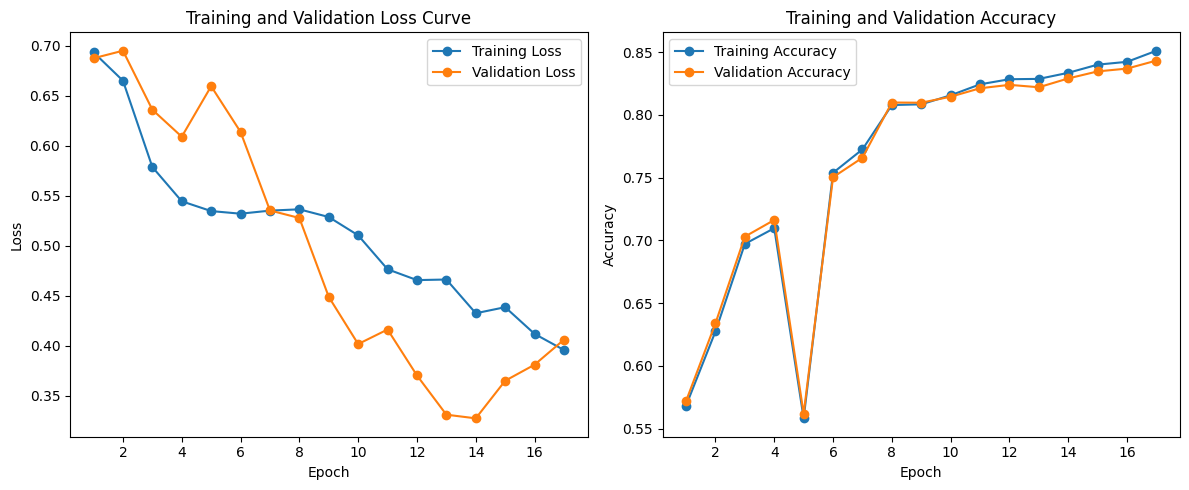

In [ ]:
plt.figure(figsize=(12, 5))

# plotting the loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(development_losses) + 1), development_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, len(development_accuracies) + 1), development_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The trainining and validation loss as well as the accuracy after training with the hyperparameters we found made the model perform the best. (We added the photo below just in case).

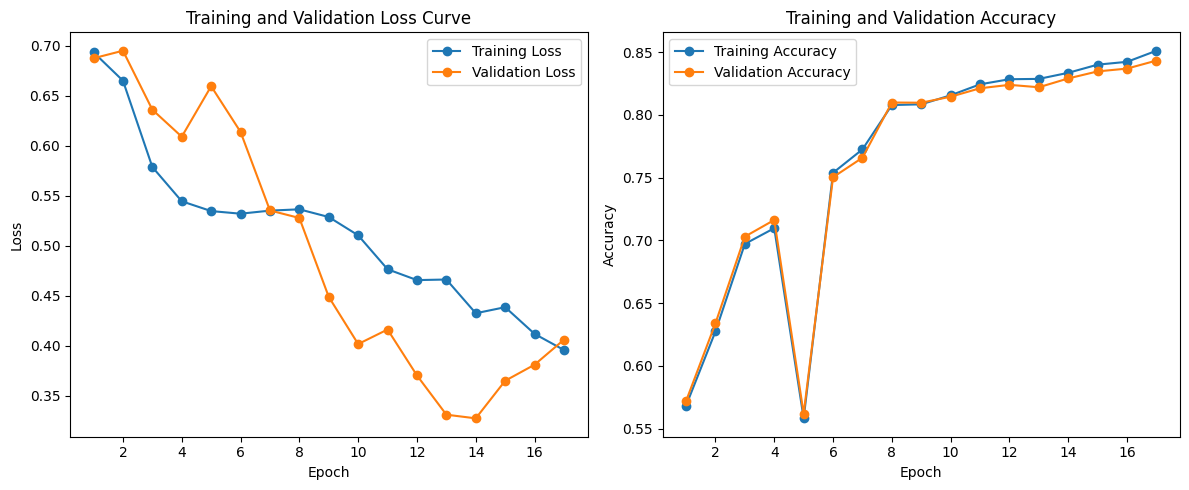